In [9]:
# Always start with checking out the files!
!ls ../input/*

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
# Importing required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


In [24]:
# Algorithms to use for time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [25]:
# Import all of the data frames 
sales = pd.read_csv(r"C:\Users\Nathan Campbell\Documents\Machine Leaning\ML project\Data sets\sales_train.csv")

item_cat = pd.read_csv(r"C:\Users\Nathan Campbell\Documents\Machine Leaning\ML project\Data sets\item_categories.csv")

item = pd.read_csv(r"C:\Users\Nathan Campbell\Documents\Machine Leaning\ML project\Data sets\items.csv")

sub = pd.read_csv(r"C:\Users\Nathan Campbell\Documents\Machine Leaning\ML project\Data sets\sample_submission.csv")

shops = pd.read_csv(r"C:\Users\Nathan Campbell\Documents\Machine Leaning\ML project\Data sets\shops.csv")

test = pd.read_csv(r"C:\Users\Nathan Campbell\Documents\Machine Leaning\ML project\Data sets\sales_test.csv")


In [26]:
# Here is where the formatting of the dates will be done correctly (Day - Month - Year)
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

# Checking if it was done correctly
print(sales.info())

#dont worry if it tales long for this part to process remember this is 2 years of data...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [28]:
# Organizing the columns and providing additional informations for further analysis
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

# Checking to see if this was done correctly
monthly_sales.head(10)

# Again is this takes a while to load dont stress about it

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0

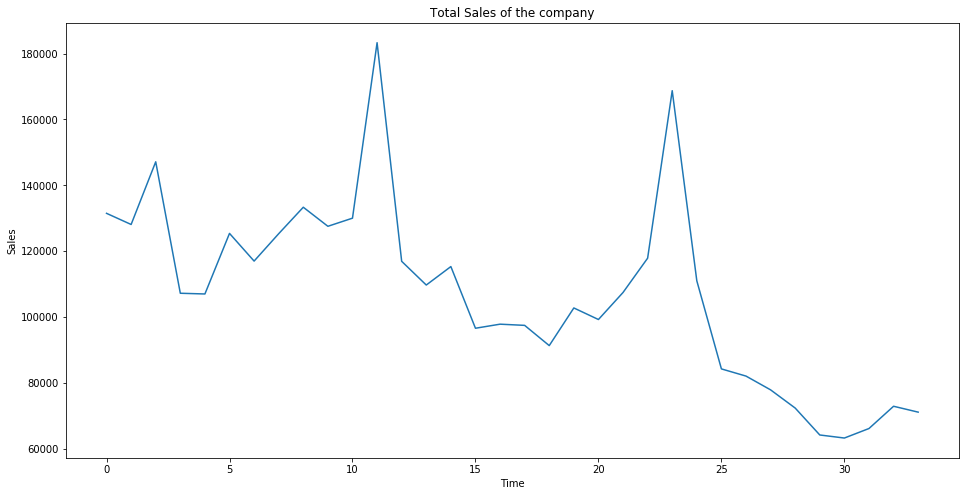

In [30]:
# Here we will plot a monthly analysis on the sales
time_series=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
time_series.astype('float')
plt.figure(figsize = (16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(time_series);

# As you can see there are seasonal fluctuations in the behaivour of the sales of this company


In [35]:
# Now we will check if the model is stationary
# There are multiple tests which can be used to check if the model is station but in our case we'll use
# Perform Dickey-Fuller test. It is the most common method used.
# Time series assume the model is stationary so lets make it that way.

def test_stationarity(timeseries):

    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag = 'AIC')
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print (df_output)

test_stationarity(time_series)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [36]:
# We will now remove noise from the model. Our p-value is very large.

# To remove trend
from pandas import Series as Series

# Create a differenced series
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# Invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob


[]

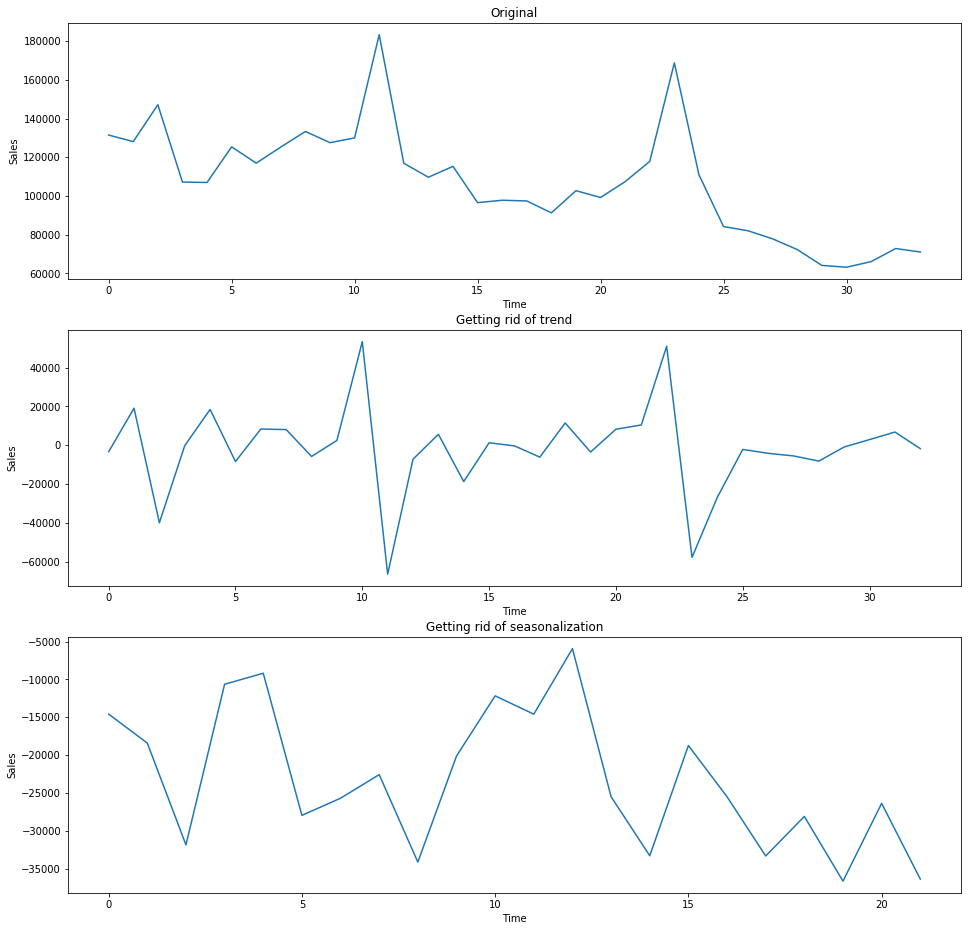

In [37]:
# Here we will visualize it to see if the model is becoming stationary or not
time_series=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
time_series.astype('float')
plt.figure(figsize = (16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(time_series)

# This is after taking out the trends noise
plt.subplot(312)
plt.title('Getting rid of trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_time_series = difference(time_series)
plt.plot(new_time_series)
plt.plot()

# This is taking out seasonal noise
plt.subplot(313)
plt.title('Getting rid of seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_time_series = difference(time_series,12)       #seasonality is 12 months long
plt.plot(new_time_series)
plt.plot()

In [39]:
# Using the Dickey-Fuller test to check if the data set is stationary after the transformation applied
test_stationarity(new_time_series)

# Since or p > 0.05 we can assume that the model is stationary


Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [41]:
# Making a function to show the graphs which the time series will produce
def time_series_plot(y, lags = None, figsize = (10, 8), style = 'bmh',title = ''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

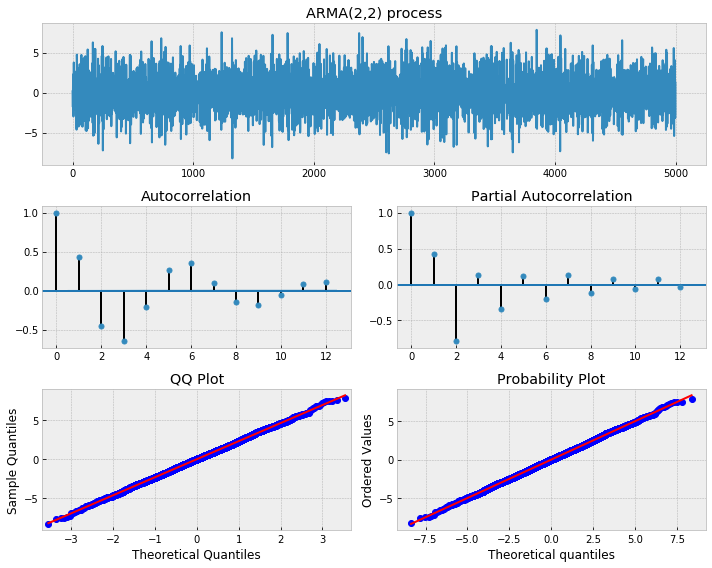

In [43]:
# Here we are going to make an ARMA (Auto Regressive Moving Average) model and ee what order it has

# Simulate an ARMA(2, 2) model with 
#alphas = [0.5,-0.25] and betas = [0.5,-0.3]

max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n, burnin = burn)
_ = time_series_plot(arma22, lags = max_lag, title = "ARMA(2,2) process")

In [45]:
# Here we are going to make an ARMA (Auto Regressive Moving Average) model and see what order it has

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order = (i, j)).fit(method = 'mle', trend = 'nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15377.64067 | order: (2, 2)


In [48]:
# Adding the date so it makes sense
time_series=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
time_series.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
time_series=time_series.reset_index()
time_series.head()


,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0
